In [55]:
# some imports
import os
from functools import reduce
import operator
from skimage.draw import polygon
from scipy import interpolate
import numpy as np
np.random.seed(seed=1)
from glob import glob
from matplotlib import pyplot as plt
%matplotlib notebook
from natsort import natsorted
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# import custom functions and viewing tools
from VisTools import multi_slice_viewer0, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss

In [36]:
#~# some parameters to set for training #~#
# path to save best model weights
model_version = 4
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_v{:02d}.h5'.format(model_version))
# set number of unique subjects to be used for testing
test_num = 3
# set number of unique subjects to to be used for validation
val_num = 3
# whether to use data augmentation or not
augment = True
# how many iterations of data to train on
numEp = 100
# augmentation factor
augFact = 4

# set data directory
data_dir = os.path.join('/home','johnsonj118','output')

In [56]:
# find unique subjects
all_inputs = natsorted(glob(os.path.join(data_dir,"input*.npy")))
all_targets = natsorted(glob(os.path.join(data_dir,"target*.npy")))
stems = [f[:-12] for f in all_inputs]
unq_stems = np.unique(stems)
# get number of unique subjects
numSubjs = len(unq_stems)
print('{} total scans found'.format(len(all_inputs)))
print('{} unique subjects'.format(numSubjs))
# group repeated scans together
groupings = [[i for i, e in enumerate(stems) if e == u] for u in unq_stems]
grouped_inputs = [[all_inputs[g] for g in group] for group in groupings]
grouped_targets = [[all_targets[g] for g in group] for group in groupings]

44 total scans found
16 unique subjects


In [57]:
# Randaomly select test subject indices
# numpy is seeded so this is repeatable
tv_inds = np.random.choice(numSubjs,test_num+val_num,replace=False)
test_inds = tv_inds[:test_num]
val_inds = tv_inds[test_num:]

In [58]:
# split into test,train,validation
# grab testing files and reduce to a single list
input_files_test = reduce(operator.add,[grouped_inputs[i] for i in test_inds])
target_files_test = reduce(operator.add,[grouped_targets[i] for i in test_inds])
# grab validation files and reduce to a single list
input_files_val = reduce(operator.add,[grouped_inputs[i] for i in val_inds])
target_files_val = reduce(operator.add,[grouped_targets[i] for i in val_inds])
# remove testing and validation files from lists
# and take what's left as training files
for i in tv_inds:
    grouped_inputs.pop(i)
    grouped_targets.pop(i)
input_files_train = reduce(operator.add,grouped_inputs)
target_files_train = reduce(operator.add,grouped_targets)
# get list of file indices of test files for
# future reference
test_file_inds = reduce(operator.add,[groupings[i] for i in test_inds])
print('The test file indices are:')
print(test_file_inds)

The test file indices are:
[9, 10, 11, 35, 36, 37, 19, 20, 21]


In [6]:
# load input data
print('Loading input data...')
inputs_test = np.concatenate([np.load(f) for f in input_files_test])
inputs_val = np.concatenate([np.load(f) for f in input_files_val])
inputs_train = np.concatenate([np.load(f) for f in input_files_test])
# add singleton dimension for grayscale channel
testX = inputs_test[...,np.newaxis]
valX = inputs_val[...,np.newaxis]
trainX = inputs_train[...,np.newaxis]
print('Input data loaded')

Loading input data...
Input data loaded


In [7]:
# load target data
print('Loading target data...')
targets_test = np.concatenate([np.load(f) for f in target_files_test])
targets_val = np.concatenate([np.load(f) for f in target_files_val])
targets_train = np.concatenate([np.load(f) for f in target_files_test])
# add singleton dimension for grayscale channel
testY = targets_test[...,np.newaxis]
valY = targets_val[...,np.newaxis]
trainY = targets_train[...,np.newaxis]
print('Target data loaded')

Loading target data...
Target data loaded


In [8]:
# make model
model = BlockModel(trainX.shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(), loss=dice_coef_loss)

In [9]:
# setup image data generator
if augment:
    datagen1 = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
    datagen2 = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
else:
    datagen1 = ImageDataGenerator()
    datagen2 = ImageDataGenerator()
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
datagen1.fit(trainX, seed=seed)
datagen2.fit(trainY, seed=seed)
batchsize = 16
datagen = zip( datagen1.flow( trainX, None, batchsize, seed=seed), datagen2.flow( trainY, None, batchsize, seed=seed) )

# calculate number of batches
if augment:
    steps = np.int(trainX.shape[0]/batchsize*augFact)
else:
    steps = np.int(trainX.shape[0]/batchsize)

In [10]:
# make callback for checkpointing
cb_check = ModelCheckpoint(model_weights_path,monitor='val_loss',
                                   verbose=0,save_best_only=True,
                                   save_weights_only=True,mode='auto',period=1)

In [11]:
# train model
history = model.fit_generator(datagen,
                    steps_per_epoch=steps,
                    epochs=numEp,
                    callbacks=[cb_check],
                    verbose=1,
                    validation_data=(valX,valY))

Epoch 1/100
66/66 [==============================] - 49s 738ms/step - loss: 0.4797 - val_loss: 0.8771
Epoch 2/100
66/66 [==============================] - 33s 506ms/step - loss: 0.2806 - val_loss: 0.5901
Epoch 3/100
66/66 [==============================] - 36s 546ms/step - loss: 0.2414 - val_loss: 0.3540
Epoch 4/100
66/66 [==============================] - 35s 535ms/step - loss: 0.2062 - val_loss: 0.6356
Epoch 5/100
66/66 [==============================] - 36s 540ms/step - loss: 0.1769 - val_loss: 0.2649
Epoch 6/100
66/66 [==============================] - 35s 533ms/step - loss: 0.1874 - val_loss: 0.4601
Epoch 7/100
66/66 [==============================] - 36s 539ms/step - loss: 0.1537 - val_loss: 0.9063
Epoch 8/100
66/66 [==============================] - 35s 532ms/step - loss: 0.1430 - val_loss: 0.7294
Epoch 9/100
66/66 [==============================] - 36s 546ms/step - loss: 0.1328 - val_loss: 0.2653
Epoch 10/100
66/66 [==============================] - 35s 534ms/step - loss: 0.118

66/66 [==============================] - 36s 543ms/step - loss: 0.0404 - val_loss: 0.1438
Epoch 81/100
66/66 [==============================] - 36s 541ms/step - loss: 0.0393 - val_loss: 0.1699
Epoch 82/100
66/66 [==============================] - 36s 547ms/step - loss: 0.0372 - val_loss: 0.1157
Epoch 83/100
66/66 [==============================] - 35s 536ms/step - loss: 0.0372 - val_loss: 0.1499
Epoch 84/100
66/66 [==============================] - 36s 539ms/step - loss: 0.0408 - val_loss: 0.1692
Epoch 85/100
66/66 [==============================] - 35s 534ms/step - loss: 0.0439 - val_loss: 0.4173
Epoch 86/100
66/66 [==============================] - 36s 541ms/step - loss: 0.0406 - val_loss: 0.1256
Epoch 87/100
66/66 [==============================] - 35s 534ms/step - loss: 0.0419 - val_loss: 0.1564
Epoch 88/100
66/66 [==============================] - 35s 530ms/step - loss: 0.0489 - val_loss: 0.9348
Epoch 89/100
66/66 [==============================] - 35s 534ms/step - loss: 0.0502 - 

<IPython.core.display.Javascript object>


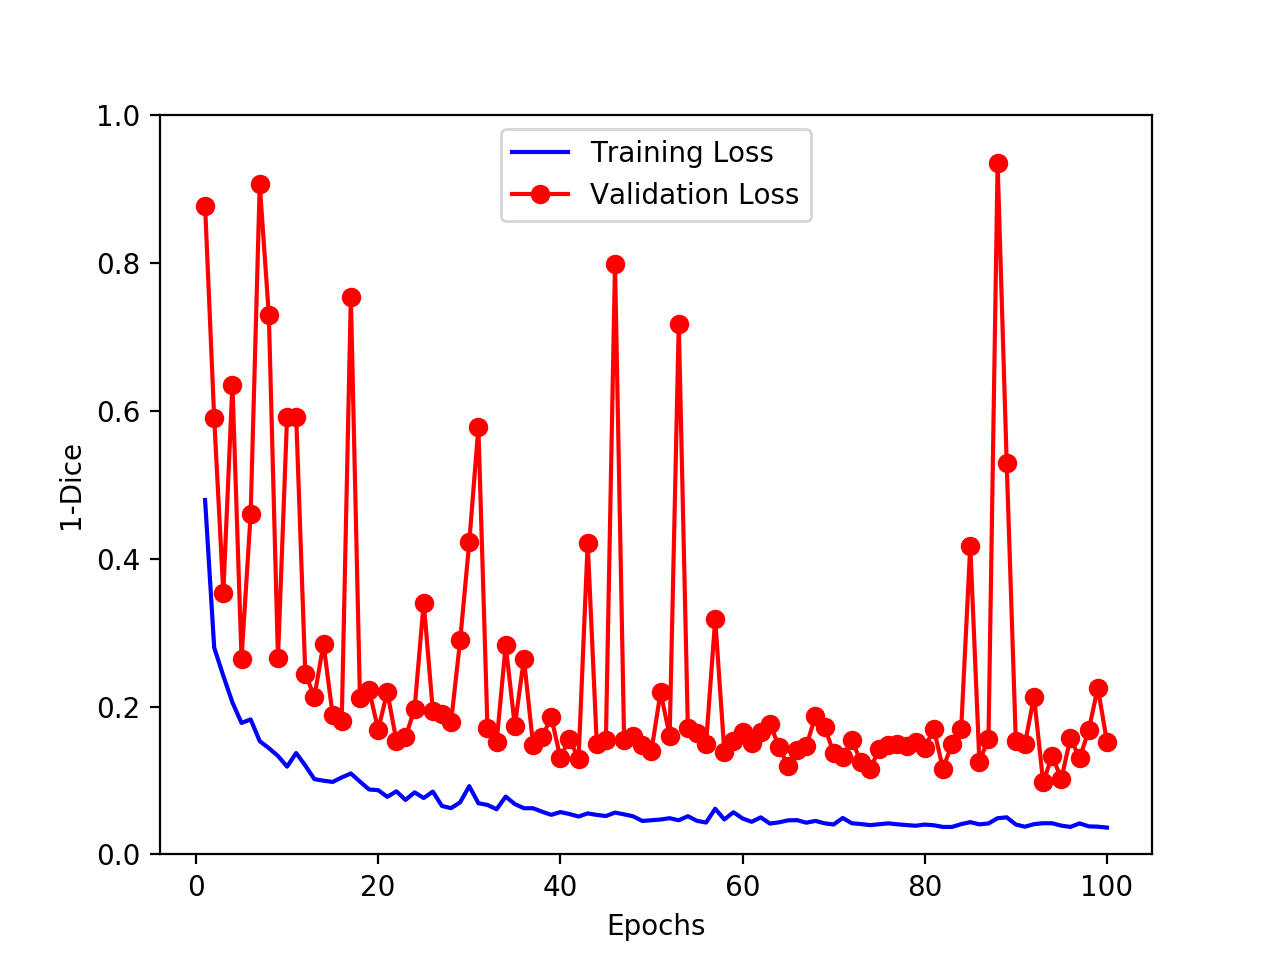

In [97]:
# Plot loss curves
epochs = np.arange(1,len(history.history['loss'])+1)
plt.figure()
plt.plot(epochs,history.history['loss'],'b-')
plt.plot(epochs,history.history['val_loss'],'r-o')
plt.xlabel('Epochs')
plt.ylabel('1-Dice')
plt.ylim([0,1])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [98]:
# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
score = model.evaluate(testX,testY,verbose=0)
print("Test Dice score is {:.03f}".format(1-score))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

<IPython.core.display.Javascript object>


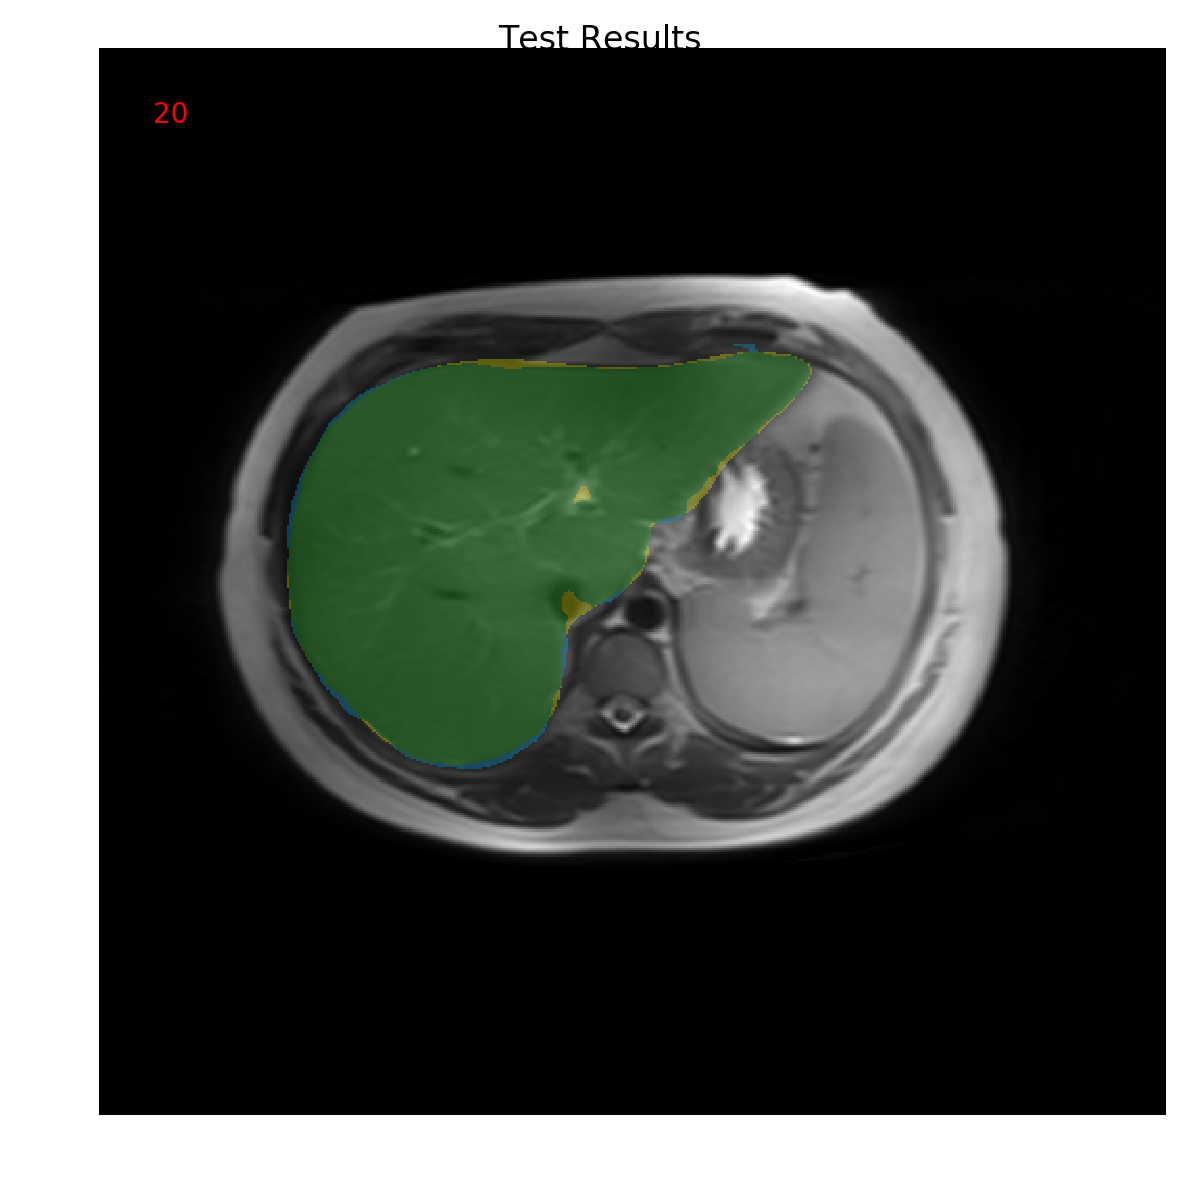

In [75]:
# display some results
output = model.predict(testX,batch_size=16)
mask_viewer0(testX[...,0],testY[...,0],output[...,0],name='Test Results')
plt.show()

This set of cells can be run independently to get predicted volumes

In [60]:
import os
from KerasModel import CalcVolumes
from natsort import natsorted
from glob import glob
# set data directory
data_dir = os.path.join('/home','johnsonj118','output')
# set voxel dimensions (in cm)
sx = .7
sy = .1
sz = .2
vox_vol = sx*sy*sz
# select which model to load
model_version = 4
# test file indices- copy and paste from
# cell 5 output
test_inds = [9, 10, 11, 35, 36, 37, 19, 20, 21]
# get input/target files
input_files= natsorted(glob(os.path.join(data_dir, "input*.npy")))
target_files= natsorted(glob(os.path.join(data_dir, "target*.npy")))
test_input_files = [input_files[i] for i in test_inds]
test_target_files = [target_files[i] for i in test_inds]
# create model
from KerasModel import BlockModel
model = BlockModel((1,512,512,1),filt_num=16,numBlocks=4)
# load saved weights
model_weights_path = os.path.join(os.getcwd(),'BestModelWeights_v{:02d}.h5'.format(model_version))
model.load_weights(model_weights_path)

In [61]:
# choose subject to calculate volume of
subj_ind = 3
# run function to perform calculations
calc,truth = CalcVolumes(input_files[subj_ind],target_files[subj_ind],vox_vol,model)
# display result
print("The calculated volume is {:.02f} cm^3".format(calc))
print("The actual volume is {:.02f} cm^3".format(truth))

The calculated volume is 2604.53 cm^3
The actual volume is 2731.25 cm^3


In [67]:
# Get all volumes and plot correlation plot
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
results = [CalcVolumes(inp,targ,vox_vol,model) for inp,targ in zip(test_input_files,test_target_files)]

<IPython.core.display.Javascript object>


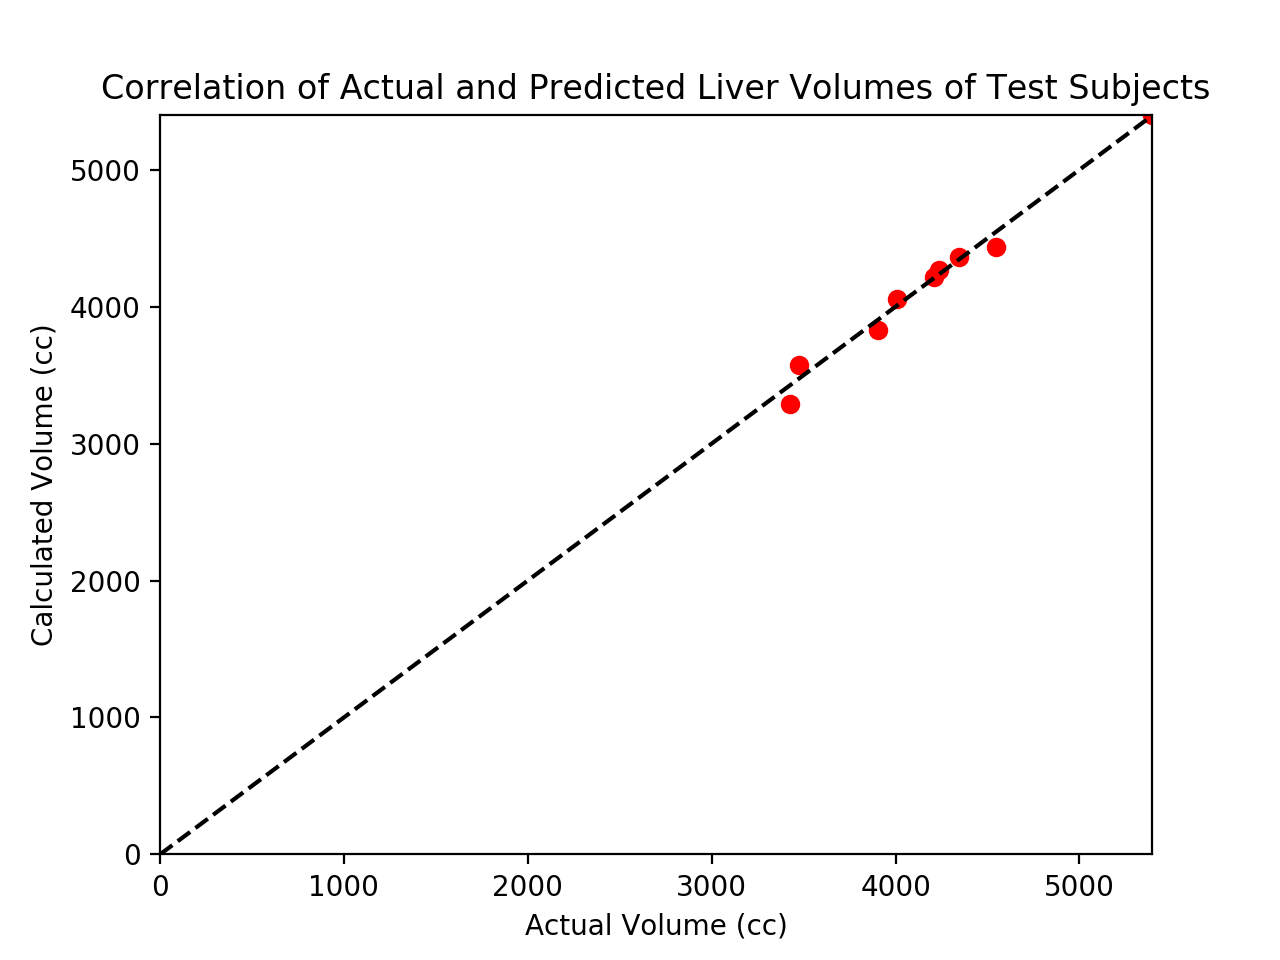

Correlation coefficient is 0.992


In [93]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.figure()
plt.plot(x,y,'ro')
plt.plot(np.arange(0,np.max(x)),np.arange(0,np.max(x)),'k--')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.title("Correlation of Actual and Predicted Liver Volumes of Test Subjects")
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))